### 신경망 학습의 목적
: 손실 함수의 값을 가능한 한 낮추는 매개변수 찾는 것 

: 이는 매개변수의 최적값 찾는 문제 

→ 최적화 : 이러한 문제 찾는 것


#### • 확률적 경사 하강법(SGD)
: 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가가는 방법

: 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자는 것

In [2]:
# SGD 구현
class SGD:
    def __init__(self, lr=0.01):
     self.lr = lr  # lr = learning rate(학습률) → 인스턴스 변수로 유지
 
    def update(self, params, grads): # SGD 과정에서 반복해서 불린다. 
        for key in params.key():
            params[key] -= self.lr * grads[key]

#### • SGD의 단점

: 탐색 경로가 비효율적이라는 것

: 비등방성 함수 → 방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수 

: 개선해주는 모델    

ex) momentum, AdaGrad, Adam


In [ ]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None  # 인스턴스 변수 v가 물체의 속도 
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}  # v 초기화 때는 아무 값도 담지 않고, 
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] # 대신 update()가 처음 호출될 때 매개변수와 같은 구조 데이터를 딕셔너리 변수로 저장
            params[key] += self.v[key]

# 공이 그릇 바닥을 구르듯 움직인다. x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문
# 거꾸로 y축의 힘은 크지만 위아래로 번갈아 받아 상충하여 y축 방향의 속도는 안정적이지 않다.  
# 전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어든다.

### AdaGrad 

- 학습률 값이 너무 작으면 학습 시간이 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이뤄지지 않는다. 

  → 학습률 감소 : 이 학습률을 정하는 효과적 기술 / 학습 진행하면서 학습률 줄여가는 방법 


- 학습률 서서히 낮추는 가장 간단한 방법 : 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것




In [5]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 1e-7이라는 값 더하는 부분 

### Adam

- AdaGrad, Momentum 융합하여 시작한 기법

- 매개변수 공간을 효율적으로 탐색 / 하이퍼파라미터의 '편향 보정' 진행 

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

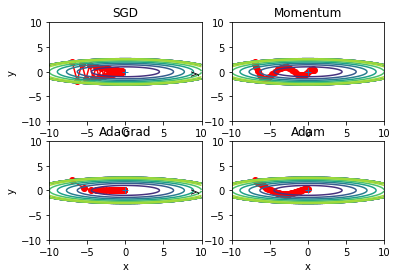

In [6]:
import sys, os
sys.path.append("/Users/krc/Downloads/deep-learning-from-scratch-master")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# AdaGrad가 가장 나은거 같은데, 풀어야 할 문제가 무엇이냐에 따라 달라짐
# (학습률 등의) 하이퍼파라미터를 어떻게 설정하느냐에 따라 결과가 바뀐다.

===========iteration:0===========
SGD:2.426717318911253
Momentum:2.337327275068792
AdaGrad:2.286424091247369
Adam:2.141201300674293
===========iteration:100===========
SGD:1.8457801910954685
Momentum:0.280697194303796
AdaGrad:0.1150760166056898
Adam:0.21619488925563923
===========iteration:200===========
SGD:1.0546805130841115
Momentum:0.20812485807079145
AdaGrad:0.12478511795044295
Adam:0.20414392559890215
===========iteration:300===========
SGD:0.5255161594690169
Momentum:0.1878412037195618
AdaGrad:0.12634534950402387
Adam:0.15941048457454285
===========iteration:400===========
SGD:0.4525932505632486
Momentum:0.25688108230969076
AdaGrad:0.11048353377660114
Adam:0.19845548292006052
===========iteration:500===========
SGD:0.2855132538623474
Momentum:0.12119295808169422
AdaGrad:0.06168447094204624
Adam:0.07841420913887621
===========iteration:600===========
SGD:0.34702880767373867
Momentum:0.125064053587633
AdaGrad:0.07362682839899588
Adam:0.10611410347521569
===========iteration:700===

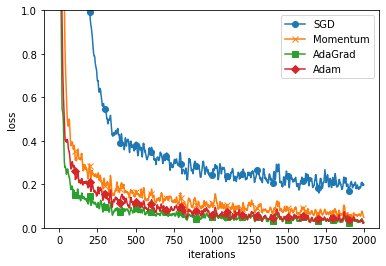

In [7]:
import os
import sys
sys.path.append("/Users/krc/Downloads/deep-learning-from-scratch-master")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# SGD의 학습 진도가 가장 느리다. 하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라진다.


### ★ 가중치의 초깃값 ★    
신경망 학습에서 가장 중요!!  


: 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패가 가르는 일이 자주 있다. 

#### • 가중치 감소 기법

: 가중치 매개변수의 값이 작아지도록 학습하는 방법 

→ 가중치 값을 작게 하여 오버피팅이 일어나지 않게 하는 것  

• 초깃값을 모두 0으로 해서는 안 되는 이유는 ?

: 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문

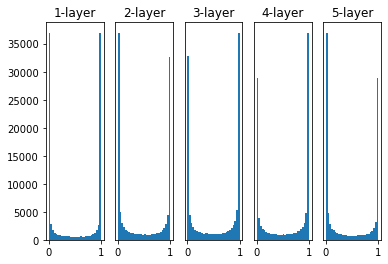

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0:
        plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))

plt.show()

# 층 5개, 각 층의 뉴런 100개씩. 입력 데이터로 1,000개의 데이터를 정규분포로 무작위로 생성하여 5층 신경망에 흘림
# 활성화 함수로 시그모이드 함수 사용, 각 층의 활성화 결과 activations 변수에 저장
# 그래프 보면 각 층의 활성화값들이 0과 1에 치우쳐 분포 → 시그모이드 함수는 출력이 0에 가까워지자(1에 가까워지자) 미분은 0에 다가간다.
# 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다. 
# "기울기 소실"

In [27]:
# Xavier 초깃값

node_num = 100
w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

#### • Xavier 초깃값 

: 층이 깊어지면서 치우침이 조금씩 커짐 

: 실제로 층이 깊어지면 활성화값들의 치우침도 커지고, 학습할 때 '기울기 소실' 문제를 일으킨다.


#### • He 초깃값

: 모든 층에서 균일하게 분포됨

: 층이 깊어져도 분포가 균일하게 유지되어 역전파 때도 적절한 값이 나올 것으로 기대

##### ► 활성화 함수로 ReLU 사용할 땐 He 초깃값, sigmoid나 tanh 등 s자 모양 곡선일 때는 Xavier 초깃값 사용 

===========iteration:0===========
std=0.01:2.30244159431867
Xavier:2.296021978232713
He:2.3144494759573986
===========iteration:100===========
std=0.01:2.302289555421056
Xavier:2.2542044305935667
He:1.4173255239105322
===========iteration:200===========
std=0.01:2.301890491875098
Xavier:2.114717497633113
He:0.7204868480480419
===========iteration:300===========
std=0.01:2.30358767981384
Xavier:1.8466069845290227
He:0.5074167536942169
===========iteration:400===========
std=0.01:2.3036146320678346
Xavier:1.264618385674354
He:0.3852151371916603
===========iteration:500===========
std=0.01:2.299974182234336
Xavier:0.8917565827477396
He:0.39925592169257307
===========iteration:600===========
std=0.01:2.3024806653343357
Xavier:0.6724621180804109
He:0.3010217819355009
===========iteration:700===========
std=0.01:2.3082560463805555
Xavier:0.6540669467289986
He:0.35985078967033557
===========iteration:800===========
std=0.01:2.3025678726521157
Xavier:0.6253558142875945
He:0.37412501616458405
=

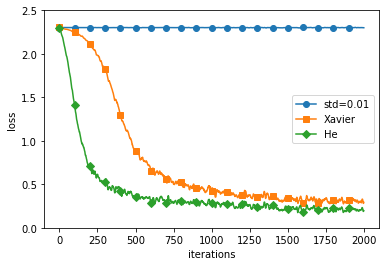

In [28]:
# MNIST 데이터셋으로 본 가중치 초깃값 비교
import os
import sys

sys.path.append('/Users/krc/Downloads/deep-learning-from-scratch-master/ch06')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 층별 뉴런 수가 100개인 5층 신경망에서 활성화 함수로 ReLU tkdyd 
# std = 0.01일 땐 학습이 이뤄지지 않는다. → 순전파 때 너무 작은 값(0 근처로 밀집한 데이터) 흐르기 때문 
# 역전파 때의 기울기도 작아져 가중치가 거의 갱신되지 않음


### 배치 정규화 

- 학습을 빨리 진행할 수 있다. (학습 속도 개선)

- 초깃값에 크게 의존하지 않는다. (골치 아픈 초깃갑 선택 안해도 됨)

- 오버피팅을 억제한다. (드롭아웃 등의 필요성 감소)

#### 
▶︎ 초깃값에 크게 신경 쓸 필요가 없고, 오버피팅 억제 효과가 있다는 점

============== 1/16 ==============
epoch:0 | 0.1 - 0.064


/Users/krc/Downloads/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/Users/krc/Downloads/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.085
epoch:2 | 0.097 - 0.141
epoch:3 | 0.097 - 0.172
epoch:4 | 0.097 - 0.191
epoch:5 | 0.097 - 0.201
epoch:6 | 0.097 - 0.226
epoch:7 | 0.097 - 0.24
epoch:8 | 0.097 - 0.262
epoch:9 | 0.097 - 0.272
epoch:10 | 0.097 - 0.284
epoch:11 | 0.097 - 0.315
epoch:12 | 0.097 - 0.333
epoch:13 | 0.097 - 0.339
epoch:14 | 0.097 - 0.343
epoch:15 | 0.097 - 0.373
epoch:16 | 0.097 - 0.386
epoch:17 | 0.097 - 0.397
epoch:18 | 0.097 - 0.424


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.416
============== 2/16 ==============
epoch:0 | 0.097 - 0.127
epoch:1 | 0.097 - 0.113


/Users/krc/Downloads/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/Users/krc/Downloads/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/Users/krc/miniforge3/envs/krc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:2 | 0.097 - 0.129
epoch:3 | 0.097 - 0.137
epoch:4 | 0.097 - 0.157
epoch:5 | 0.097 - 0.172
epoch:6 | 0.097 - 0.192
epoch:7 | 0.097 - 0.218
epoch:8 | 0.097 - 0.248
epoch:9 | 0.097 - 0.262
epoch:10 | 0.097 - 0.298
epoch:11 | 0.097 - 0.311
epoch:12 | 0.097 - 0.327
epoch:13 | 0.097 - 0.352
epoch:14 | 0.097 - 0.37
epoch:15 | 0.097 - 0.406
epoch:16 | 0.097 - 0.42
epoch:17 | 0.097 - 0.44


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.097 - 0.455
epoch:19 | 0.097 - 0.464
============== 3/16 ==============
epoch:0 | 0.137 - 0.144
epoch:1 | 0.361 - 0.148
epoch:2 | 0.517 - 0.155
epoch:3 | 0.611 - 0.188
epoch:4 | 0.681 - 0.212
epoch:5 | 0.736 - 0.26
epoch:6 | 0.792 - 0.293
epoch:7 | 0.825 - 0.327
epoch:8 | 0.863 - 0.354
epoch:9 | 0.894 - 0.385
epoch:10 | 0.899 - 0.421
epoch:11 | 0.918 - 0.446
epoch:12 | 0.935 - 0.469
epoch:13 | 0.95 - 0.505
epoch:14 | 0.957 - 0.517
epoch:15 | 0.967 - 0.549
epoch:16 | 0.97 - 0.563
epoch:17 | 0.98 - 0.59
epoch:18 | 0.984 - 0.598


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.988 - 0.614
============== 4/16 ==============
epoch:0 | 0.108 - 0.1
epoch:1 | 0.194 - 0.107
epoch:2 | 0.34 - 0.18
epoch:3 | 0.445 - 0.267
epoch:4 | 0.55 - 0.347
epoch:5 | 0.602 - 0.397
epoch:6 | 0.654 - 0.469
epoch:7 | 0.682 - 0.511
epoch:8 | 0.715 - 0.565
epoch:9 | 0.735 - 0.595
epoch:10 | 0.753 - 0.623
epoch:11 | 0.769 - 0.651
epoch:12 | 0.778 - 0.677
epoch:13 | 0.804 - 0.689
epoch:14 | 0.818 - 0.703
epoch:15 | 0.836 - 0.727
epoch:16 | 0.837 - 0.74
epoch:17 | 0.847 - 0.76


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.848 - 0.769
epoch:19 | 0.865 - 0.787
============== 5/16 ==============
epoch:0 | 0.095 - 0.099
epoch:1 | 0.101 - 0.126
epoch:2 | 0.109 - 0.247
epoch:3 | 0.117 - 0.377
epoch:4 | 0.138 - 0.501
epoch:5 | 0.149 - 0.609
epoch:6 | 0.183 - 0.672
epoch:7 | 0.198 - 0.709
epoch:8 | 0.207 - 0.737
epoch:9 | 0.224 - 0.773
epoch:10 | 0.231 - 0.784
epoch:11 | 0.243 - 0.8
epoch:12 | 0.253 - 0.81
epoch:13 | 0.253 - 0.827
epoch:14 | 0.252 - 0.836
epoch:15 | 0.254 - 0.848
epoch:16 | 0.259 - 0.862
epoch:17 | 0.27 - 0.87
epoch:18 | 0.276 - 0.88


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.279 - 0.889
============== 6/16 ==============
epoch:0 | 0.132 - 0.111
epoch:1 | 0.118 - 0.199
epoch:2 | 0.117 - 0.403
epoch:3 | 0.117 - 0.535
epoch:4 | 0.117 - 0.613
epoch:5 | 0.118 - 0.674
epoch:6 | 0.122 - 0.731
epoch:7 | 0.117 - 0.78
epoch:8 | 0.117 - 0.815
epoch:9 | 0.117 - 0.837
epoch:10 | 0.117 - 0.857
epoch:11 | 0.117 - 0.873
epoch:12 | 0.117 - 0.888
epoch:13 | 0.117 - 0.904
epoch:14 | 0.117 - 0.908
epoch:15 | 0.117 - 0.918
epoch:16 | 0.117 - 0.922
epoch:17 | 0.117 - 0.933


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.935
epoch:19 | 0.117 - 0.94
============== 7/16 ==============
epoch:0 | 0.093 - 0.089
epoch:1 | 0.116 - 0.253
epoch:2 | 0.116 - 0.619
epoch:3 | 0.116 - 0.706
epoch:4 | 0.116 - 0.739
epoch:5 | 0.116 - 0.781
epoch:6 | 0.116 - 0.809
epoch:7 | 0.117 - 0.831
epoch:8 | 0.117 - 0.876
epoch:9 | 0.117 - 0.899
epoch:10 | 0.117 - 0.921
epoch:11 | 0.117 - 0.942
epoch:12 | 0.117 - 0.949
epoch:13 | 0.117 - 0.957
epoch:14 | 0.117 - 0.966
epoch:15 | 0.117 - 0.976
epoch:16 | 0.117 - 0.977
epoch:17 | 0.117 - 0.982


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.984
epoch:19 | 0.117 - 0.984
============== 8/16 ==============
epoch:0 | 0.087 - 0.083
epoch:1 | 0.116 - 0.421
epoch:2 | 0.117 - 0.696
epoch:3 | 0.116 - 0.801
epoch:4 | 0.116 - 0.845
epoch:5 | 0.116 - 0.893
epoch:6 | 0.116 - 0.933
epoch:7 | 0.116 - 0.949
epoch:8 | 0.117 - 0.961
epoch:9 | 0.116 - 0.973
epoch:10 | 0.116 - 0.982
epoch:11 | 0.116 - 0.989
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.995
epoch:14 | 0.116 - 0.997
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.995
epoch:17 | 0.116 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.116 - 0.999
epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.116 - 0.108
epoch:1 | 0.116 - 0.528
epoch:2 | 0.116 - 0.653
epoch:3 | 0.117 - 0.793
epoch:4 | 0.117 - 0.874
epoch:5 | 0.116 - 0.899
epoch:6 | 0.116 - 0.934
epoch:7 | 0.116 - 0.972
epoch:8 | 0.116 - 0.985
epoch:9 | 0.116 - 0.988
epoch:10 | 0.116 - 0.995
epoch:11 | 0.117 - 0.996
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.999
============== 10/16 ==============
epoch:0 | 0.099 - 0.101
epoch:1 | 0.116 - 0.655
epoch:2 | 0.116 - 0.768
epoch:3 | 0.117 - 0.802
epoch:4 | 0.116 - 0.824
epoch:5 | 0.116 - 0.857
epoch:6 | 0.116 - 0.89
epoch:7 | 0.116 - 0.937
epoch:8 | 0.116 - 0.95
epoch:9 | 0.116 - 0.986
epoch:10 | 0.116 - 0.987
epoch:11 | 0.116 - 0.994
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 0.999
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 1.0
============== 11/16 ==============
epoch:0 | 0.087 - 0.187
epoch:1 | 0.116 - 0.611
epoch:2 | 0.116 - 0.722
epoch:3 | 0.116 - 0.789
epoch:4 | 0.116 - 0.722
epoch:5 | 0.116 - 0.835
epoch:6 | 0.116 - 0.87
epoch:7 | 0.116 - 0.889
epoch:8 | 0.116 - 0.884
epoch:9 | 0.116 - 0.857
epoch:10 | 0.116 - 0.898
epoch:11 | 0.116 - 0.983
epoch:12 | 0.116 - 0.981
epoch:13 | 0.116 - 0.991
epoch:14 | 0.116 - 0.945
epoch:15 | 0.116 - 0.993
epoch:16 | 0.116 - 0.992
epoch:17 | 0.116 - 0.99
epoch:18 | 0.116 - 0.992


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.993
============== 12/16 ==============
epoch:0 | 0.116 - 0.108
epoch:1 | 0.116 - 0.425
epoch:2 | 0.117 - 0.583
epoch:3 | 0.116 - 0.673
epoch:4 | 0.116 - 0.675
epoch:5 | 0.116 - 0.68
epoch:6 | 0.116 - 0.691
epoch:7 | 0.116 - 0.698
epoch:8 | 0.116 - 0.696
epoch:9 | 0.116 - 0.704
epoch:10 | 0.116 - 0.7
epoch:11 | 0.116 - 0.709
epoch:12 | 0.116 - 0.707
epoch:13 | 0.116 - 0.777
epoch:14 | 0.116 - 0.779
epoch:15 | 0.116 - 0.874
epoch:16 | 0.116 - 0.877
epoch:17 | 0.116 - 0.885
epoch:18 | 0.116 - 0.836
epoch:19 | 0.116 - 0.893


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 13/16 ==============
epoch:0 | 0.117 - 0.09
epoch:1 | 0.117 - 0.292
epoch:2 | 0.117 - 0.486
epoch:3 | 0.117 - 0.536
epoch:4 | 0.117 - 0.565
epoch:5 | 0.117 - 0.571
epoch:6 | 0.117 - 0.587
epoch:7 | 0.117 - 0.603
epoch:8 | 0.117 - 0.602
epoch:9 | 0.117 - 0.587
epoch:10 | 0.117 - 0.611
epoch:11 | 0.116 - 0.607
epoch:12 | 0.116 - 0.604
epoch:13 | 0.116 - 0.614
epoch:14 | 0.116 - 0.615
epoch:15 | 0.116 - 0.613
epoch:16 | 0.116 - 0.614
epoch:17 | 0.117 - 0.615
epoch:18 | 0.117 - 0.575


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.613
============== 14/16 ==============
epoch:0 | 0.117 - 0.109
epoch:1 | 0.116 - 0.481
epoch:2 | 0.117 - 0.488
epoch:3 | 0.117 - 0.521
epoch:4 | 0.117 - 0.577
epoch:5 | 0.117 - 0.576
epoch:6 | 0.117 - 0.584
epoch:7 | 0.117 - 0.602
epoch:8 | 0.117 - 0.594
epoch:9 | 0.117 - 0.61
epoch:10 | 0.117 - 0.614
epoch:11 | 0.117 - 0.617
epoch:12 | 0.117 - 0.65
epoch:13 | 0.117 - 0.681
epoch:14 | 0.117 - 0.697
epoch:15 | 0.116 - 0.696
epoch:16 | 0.116 - 0.698
epoch:17 | 0.116 - 0.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.699
epoch:19 | 0.117 - 0.697
============== 15/16 ==============
epoch:0 | 0.099 - 0.112
epoch:1 | 0.116 - 0.146
epoch:2 | 0.117 - 0.332
epoch:3 | 0.117 - 0.513
epoch:4 | 0.117 - 0.571
epoch:5 | 0.117 - 0.596
epoch:6 | 0.117 - 0.56
epoch:7 | 0.117 - 0.508
epoch:8 | 0.117 - 0.595
epoch:9 | 0.117 - 0.606
epoch:10 | 0.117 - 0.605
epoch:11 | 0.117 - 0.609
epoch:12 | 0.117 - 0.604
epoch:13 | 0.117 - 0.61
epoch:14 | 0.117 - 0.597
epoch:15 | 0.117 - 0.608
epoch:16 | 0.117 - 0.609
epoch:17 | 0.117 - 0.61
epoch:18 | 0.117 - 0.609


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.61
============== 16/16 ==============
epoch:0 | 0.117 - 0.136
epoch:1 | 0.117 - 0.316
epoch:2 | 0.117 - 0.404
epoch:3 | 0.116 - 0.404
epoch:4 | 0.116 - 0.381
epoch:5 | 0.116 - 0.422
epoch:6 | 0.116 - 0.424
epoch:7 | 0.116 - 0.426
epoch:8 | 0.116 - 0.429
epoch:9 | 0.116 - 0.429
epoch:10 | 0.116 - 0.4
epoch:11 | 0.116 - 0.429
epoch:12 | 0.116 - 0.432
epoch:13 | 0.116 - 0.432
epoch:14 | 0.116 - 0.431
epoch:15 | 0.116 - 0.432
epoch:16 | 0.116 - 0.432
epoch:17 | 0.116 - 0.433
epoch:18 | 0.116 - 0.432
epoch:19 | 0.117 - 0.432


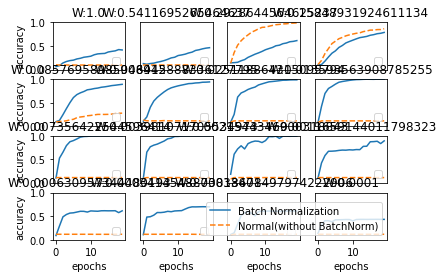

<Figure size 1800x2160 with 0 Axes>

In [34]:
# 배치 정규화 계층 사용 여부에 따른 학습 진도

import sys, os
sys.path.append('/Users/krc/Downloads/deep-learning-from-scratch-master/ch06')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.figure(figsize=(25,30))    
plt.show()

### 한 줄 정리 

: 베치 정규화를 사용하면 학습이 빨라지고, 가중치 초깃값에 크게 의존하지 않아도 된다. 